## Importance of Feature Selection

In this notebook I aim to study the importance of feature selection while building a Deep Learning model. I hypothesize that a model would be able to find out the most importance features. So, we can throw all variables in the deep learning models and its performance will not be deteriorated. 

I will check and compare the performance of models built using all features.

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=False)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [17]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 50 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 24)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [18]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 24)


In [19]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [20]:
nb_features = x_train.shape[2]
nb_out = 1

In [21]:
nb_features

24

In [22]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1
cls_wt = {0: class_1/total, 1: class_0/total}

In [23]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Experiment

In [32]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """    
    score_list = []
    for i in range(0, nruns):
        start = time.time()
        model = Sequential()
        model.add(LSTM(units=8, return_sequences=True, input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=4, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])
        model.fit(X, y, epochs=100, batch_size=64, validation_split = 0.1, verbose=0, class_weight=cls_wt,
                  shuffle=True, callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                   verbose=0, mode='auto')])
        predictions = (model.predict(X_test) > 0.5).astype("int32")
        acc = accuracy_score(y_test, predictions)
        pr = precision_score(y_test, predictions)
        rc = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        score_list.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr,
                           'Recall': rc, 'F1 Score': f1, 'AUC Score': auc})
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")
    score_df = pd.DataFrame(score_list, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score"])  
    return score_df

In [33]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns = 10)

2022-10-03 17:15:56.478048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:15:56.740410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:15:56.878938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:15:57.060684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:15:57.294861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:16:07.985770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:16:08.048373: I tensorflow/core/grappler/optimizers/cust

Run:1 and Runtime:534.28 Seconds


2022-10-03 17:24:50.586548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:24:50.763200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:24:50.994168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:24:51.265437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:24:51.748680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:25:02.086939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 17:25:02.146600: I tensorflow/core/grappler/optimizers/cust

Run:2 and Runtime:2815.881 Seconds


2022-10-03 18:11:46.726407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:46.933301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:47.067100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:47.251498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:47.488969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:58.493477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:11:58.556237: I tensorflow/core/grappler/optimizers/cust

Run:3 and Runtime:231.713 Seconds


2022-10-03 18:15:38.344811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:38.598721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:38.738567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:38.931983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:39.181317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:50.091047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:15:50.153997: I tensorflow/core/grappler/optimizers/cust

Run:4 and Runtime:300.346 Seconds


2022-10-03 18:20:38.468502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:38.635840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:38.784755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:38.965152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:39.233512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:49.653384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:20:49.713045: I tensorflow/core/grappler/optimizers/cust

Run:5 and Runtime:459.572 Seconds


2022-10-03 18:28:18.362124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:18.593806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:18.752596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:18.979426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:19.245466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:29.720946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:28:29.782347: I tensorflow/core/grappler/optimizers/cust

Run:6 and Runtime:1285.781 Seconds


2022-10-03 18:49:43.812076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:43.977583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:44.129703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:44.357084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:44.621700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:54.761323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 18:49:54.822009: I tensorflow/core/grappler/optimizers/cust

Run:7 and Runtime:1261.494 Seconds


2022-10-03 19:10:45.671820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:45.845826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:46.001288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:46.236955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:46.503935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:57.579736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:10:57.641143: I tensorflow/core/grappler/optimizers/cust

Run:8 and Runtime:250.486 Seconds


2022-10-03 19:14:56.028039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:14:56.278309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:14:56.422788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:14:56.645388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:14:56.921645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:15:08.084785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:15:08.145990: I tensorflow/core/grappler/optimizers/cust

Run:9 and Runtime:264.117 Seconds


2022-10-03 19:19:19.925186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:20.094404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:20.245584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:20.478019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:20.751580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:31.402832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:19:31.463622: I tensorflow/core/grappler/optimizers/cust

Run:10 and Runtime:670.197 Seconds


In [34]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC Score
0,1,0.88,0.821429,0.766667,0.793103,0.847619
1,2,0.71,0.508475,1.000000,0.674157,0.792857
2,3,0.87,0.869565,0.666667,0.754717,0.811905
3,4,0.92,0.866667,0.866667,0.866667,0.904762
4,5,0.93,0.848485,0.933333,0.888889,0.930952
5,6,0.90,0.812500,0.866667,0.838710,0.890476
6,7,0.87,0.742857,0.866667,0.800000,0.869048
7,8,0.84,0.652174,1.000000,0.789474,0.885714
8,9,0.87,0.774194,0.800000,0.786885,0.850000
9,10,0.96,0.906250,0.966667,0.935484,0.961905


Text(0, 0.5, 'Value')

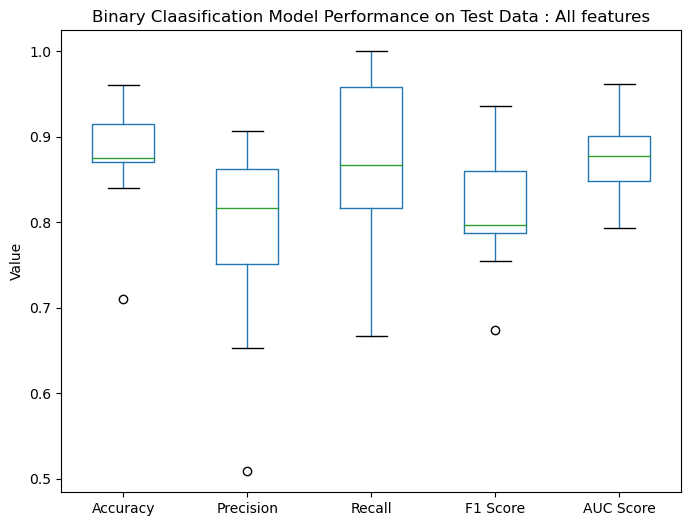

In [35]:
fig, ax = plt.subplots(figsize = (8,6))
result_df.drop(['Model'], axis = 1).boxplot(vert = 1, ax = ax)
ax.set_title('Binary Claasification Model Performance on Test Data : All features')
ax.grid(visible=None)
ax.set_ylabel('Value')

In [31]:
result_df.mean()

Model        5.500000
Accuracy     0.868000
Precision    0.755560
Recall       0.863333
F1 Score     0.797501
AUC Score    0.866667
dtype: float64